# Наивный Байес — Классификация качества красного вина

Наивный байесовский классификатор — это вероятностный метод машинного обучения, основанный на теореме Байеса с допущением о независимости признаков (отсюда «наивный»). Несмотря на это упрощённое предположение, метод часто демонстрирует хорошие результаты на практике, особенно в задачах классификации текстов, спам-фильтрации и медицинской диагностики. Для каждого класса модель вычисляет апостериорную вероятность принадлежности объекта к данному классу на основе значений его признаков, после чего объект относится к классу с наибольшей вероятностью.

## Используемые библиотеки

In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    auc
)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

print("Все библиотеки успешно импортированы!")

Все библиотеки успешно импортированы!


## Загрузка и описание датасета

https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

### Краткое описание

Датасет содержит результаты физико-химического анализа образцов португальского красного вина «Vinho Verde». Каждый образец оценён экспертами по качеству. Исходно задача регрессии (оценка от 0 до 10), но часто используется как задача классификации — например, бинарная (хорошее/плохое вино, порог 6–7) или многоклассовая.

### Параметры (признаки)

| Признак | Описание |
|---------|----------|
| `fixed acidity` | Фиксированная (нелетучая) кислотность — содержание винной кислоты (г/дм³) |
| `volatile acidity` | Летучая кислотность — содержание уксусной кислоты (г/дм³); высокие значения дают неприятный уксусный привкус |
| `citric acid` | Лимонная кислота (г/дм³) — придаёт свежесть и фруктовые нотки |
| `residual sugar` | Остаточный сахар (г/дм³) — сахар, оставшийся после ферментации |
| `chlorides` | Хлориды — содержание соли в вине (г/дм³) |
| `free sulfur dioxide` | Свободный диоксид серы (мг/дм³) — предотвращает окисление и рост микроорганизмов |
| `total sulfur dioxide` | Общий диоксид серы (мг/дм³) — сумма свободного и связанного SO₂ |
| `density` | Плотность вина (г/см³) — зависит от содержания алкоголя и сахара |
| `pH` | Кислотно-щелочной баланс (шкала 0–14); вина обычно 2.9–3.9 |
| `sulphates` | Сульфаты (г/дм³) — добавка, способствующая выделению SO₂ |
| `alcohol` | Содержание алкоголя (% об.) |

### Целевая переменная

| Переменная | Описание |
|------------|----------|
| `quality` | Оценка качества вина экспертами: целое число от **3 до 8** (исходно 0–10, но в данных представлен этот диапазон). Бинаризируем: ≤5 → «плохое», ≥6 → «хорошее» |


In [ ]:
# Загрузка данных
df = pd.read_csv('winequality-red.csv')

print("=" * 60)
print("ОСНОВНАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ")
print("=" * 60)
print(f"\nРазмерность: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"\nПервые 10 строк датасета:")
df.head(10)

ОСНОВНАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ

Размерность: 1599 строк, 12 столбцов

Первые 10 строк датасета:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [70]:
# Подробная информация о типах данных и пропусках
print("=" * 60)
print("ТИПЫ ДАННЫХ И ПРОПУСКИ")
print("=" * 60)
print()
df.info()
print(f"\nКоличество пропусков по столбцам:")
print(df.isnull().sum())
print(f"\nОбщее количество пропусков: {df.isnull().sum().sum()}")

ТИПЫ ДАННЫХ И ПРОПУСКИ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

Количество пропусков по столбцам:
fixed acidity           0
volatile acidity        0
citric acid    

In [71]:
# Подробная информация о типах данных и пропусках
print("=" * 60)
print("ТИПЫ ДАННЫХ И ПРОПУСКИ")
print("=" * 60)
print()
df.info()
print(f"\nКоличество пропусков по столбцам:")
print(df.isnull().sum())
print(f"\nОбщее количество пропусков: {df.isnull().sum().sum()}")

ТИПЫ ДАННЫХ И ПРОПУСКИ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

Количество пропусков по столбцам:
fixed acidity           0
volatile acidity        0
citric acid    

In [72]:
# Статистическое описание
print("=" * 60)
print("СТАТИСТИЧЕСКОЕ ОПИСАНИЕ")
print("=" * 60)
df.describe().round(3)

СТАТИСТИЧЕСКОЕ ОПИСАНИЕ


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000
mean,8.320,0.528,0.271,2.539,0.087,15.875,46.468,0.997,3.311,0.658,10.423,5.636
std,1.741,0.179,0.195,1.410,0.047,10.460,32.895,0.002,0.154,0.170,1.066,0.808
min,4.600,0.120,0.000,0.900,0.012,1.000,6.000,0.990,2.740,0.330,8.400,3.000
25%,7.100,0.390,0.090,1.900,0.070,7.000,22.000,0.996,3.210,0.550,9.500,5.000
50%,7.900,0.520,0.260,2.200,0.079,14.000,38.000,0.997,3.310,0.620,10.200,6.000
75%,9.200,0.640,0.420,2.600,0.090,21.000,62.000,0.998,3.400,0.730,11.100,6.000
max,15.900,1.580,1.000,15.500,0.611,72.000,289.000,1.004,4.010,2.000,14.900,8.000


РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (quality)

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


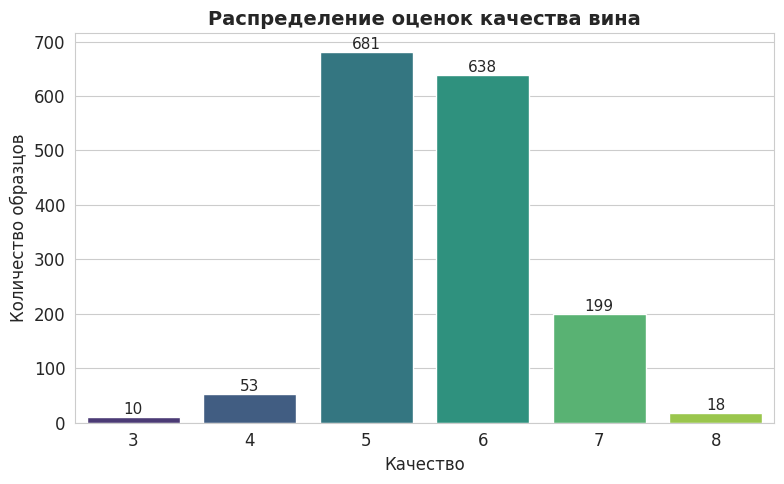

In [73]:
# Распределение целевой переменной
print("=" * 60)
print("РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (quality)")
print("=" * 60)
print()
print(df['quality'].value_counts().sort_index())

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='quality', data=df, palette='viridis')
plt.title('Распределение оценок качества вина', fontsize=14, fontweight='bold')
plt.xlabel('Качество', fontsize=12)
plt.ylabel('Количество образцов', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

## Предварительная обработка датасета

In [74]:
print("=" * 60)
print("ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ")
print("=" * 60)

# 1. Проверка и удаление дубликатов
duplicates = df.duplicated().sum()
print(f"\nКоличество дубликатов: {duplicates}")
df = df.drop_duplicates()
print(f"Размер после удаления дубликатов: {df.shape}")

ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ

Количество дубликатов: 240
Размер после удаления дубликатов: (1359, 12)



Распределение по классам после бинаризации:
  Класс 0 (низкое качество, quality ≤ 5): 640
  Класс 1 (высокое качество, quality ≥ 6): 719


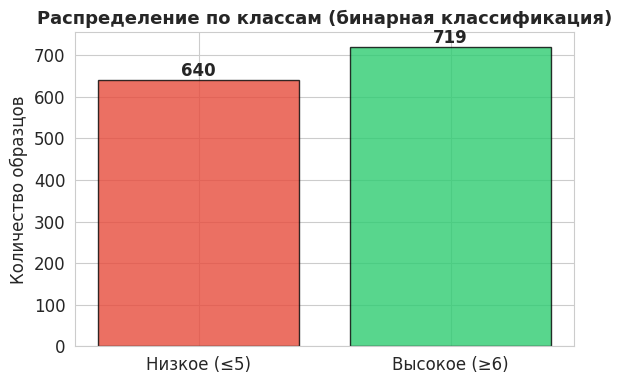

In [75]:
# 2. Бинарная классификация
df['quality_label'] = (df['quality'] >= 6).astype(int)

print(f"\nРаспределение по классам после бинаризации:")
print(f"  Класс 0 (низкое качество, quality ≤ 5): {(df['quality_label'] == 0).sum()}")
print(f"  Класс 1 (высокое качество, quality ≥ 6): {(df['quality_label'] == 1).sum()}")

# Визуализация нового распределения
plt.figure(figsize=(6, 4))
colors = ['#e74c3c', '#2ecc71']
labels = ['Низкое (≤5)', 'Высокое (≥6)']
counts = df['quality_label'].value_counts().sort_index()
plt.bar(labels, counts.values, color=colors, edgecolor='black', alpha=0.8)
for i, v in enumerate(counts.values):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold', fontsize=12)
plt.title('Распределение по классам (бинарная классификация)', fontsize=13, fontweight='bold')
plt.ylabel('Количество образцов')
plt.tight_layout()
plt.show()

In [76]:
# 3. Разделение на признаки и целевую переменную
X = df.drop(['quality', 'quality_label'], axis=1)
y = df['quality_label']

print(f"\nРазмерность матрицы признаков X: {X.shape}")
print(f"Размерность вектора целевой переменной y: {y.shape}")


Размерность матрицы признаков X: (1359, 11)
Размерность вектора целевой переменной y: (1359,)


In [77]:
# 4. Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nОбучающая выборка: {X_train.shape[0]} образцов")
print(f"Тестовая выборка:  {X_test.shape[0]} образцов")


Обучающая выборка: 951 образцов
Тестовая выборка:  408 образцов


In [78]:
# 5. Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nМасштабирование выполнено (StandardScaler)")
print(f"\nСредние значения признаков после масштабирования (обучающая выборка):")
print(pd.Series(X_train_scaled.mean(axis=0), index=X.columns).round(6))


Масштабирование выполнено (StandardScaler)

Средние значения признаков после масштабирования (обучающая выборка):
fixed acidity           0.0
volatile acidity       -0.0
citric acid             0.0
residual sugar         -0.0
chlorides              -0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                     -0.0
sulphates              -0.0
alcohol                -0.0
dtype: float64


## Тепловая карта корреляций (Heatmap)

ТЕПЛОВАЯ КАРТА КОРРЕЛЯЦИЙ


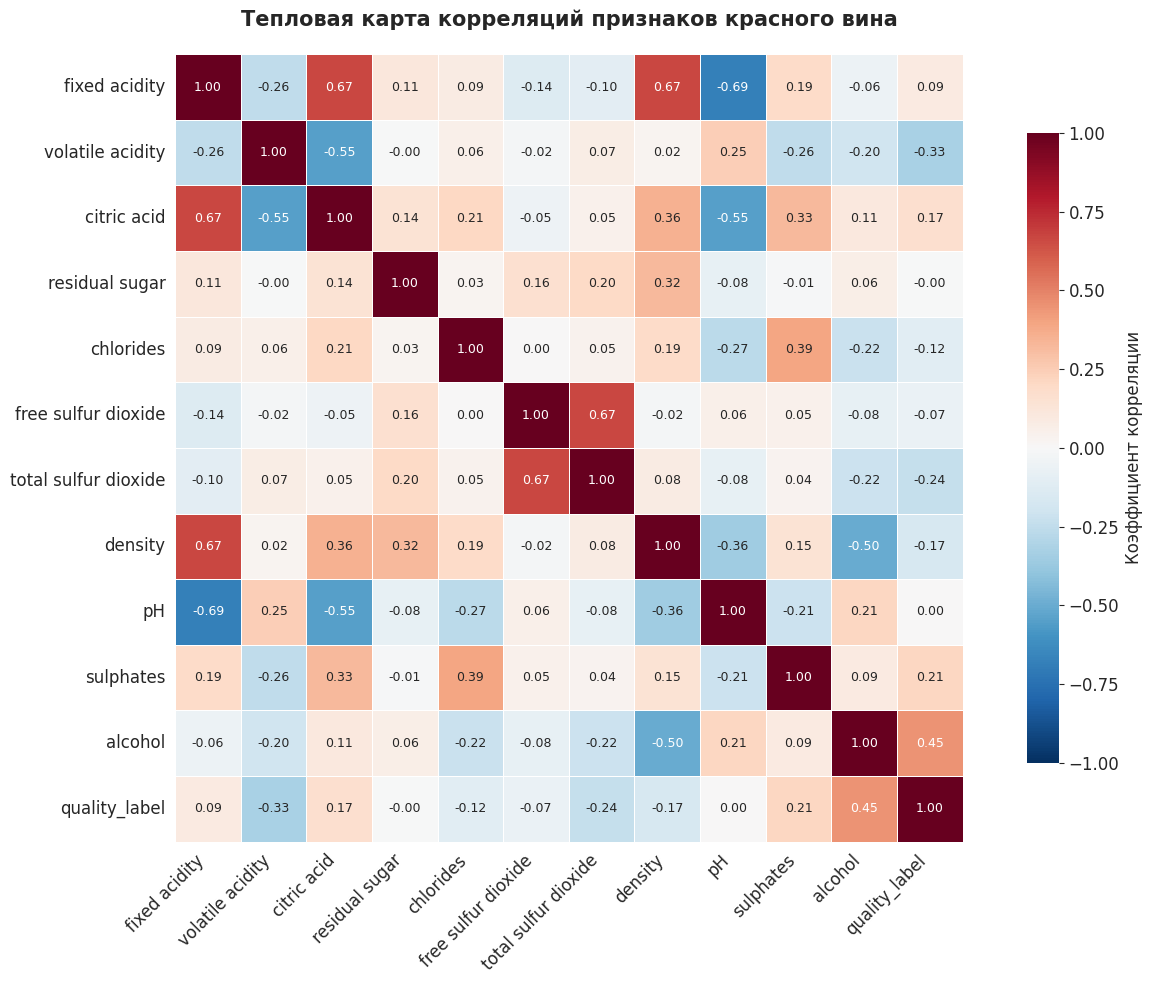

In [79]:
print("=" * 60)
print("ТЕПЛОВАЯ КАРТА КОРРЕЛЯЦИЙ")
print("=" * 60)

# Корреляционная матрица (включая целевую переменную)
df_corr = df.drop('quality', axis=1)  # оставляем quality_label
correlation_matrix = df_corr.corr()

plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8, 'label': 'Коэффициент корреляции'},
    annot_kws={'size': 9}
)
plt.title('Тепловая карта корреляций признаков красного вина',
          fontsize=15, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [80]:
# Корреляция с целевой переменной
print("\nКорреляция признаков с целевой переменной (quality_label):")
print("-" * 50)
corr_with_target = correlation_matrix['quality_label'].drop('quality_label').sort_values(ascending=False)
for feat, corr in corr_with_target.items():
    bar = '█' * int(abs(corr) * 40)
    sign = '+' if corr > 0 else '-'
    print(f"  {feat:>25s}: {corr:+.4f}  {sign} {bar}")


Корреляция признаков с целевой переменной (quality_label):
--------------------------------------------------
                    alcohol: +0.4462  + █████████████████
                  sulphates: +0.2114  + ████████
                citric acid: +0.1679  + ██████
              fixed acidity: +0.0918  + ███
                         pH: +0.0047  + 
             residual sugar: -0.0024  - 
        free sulfur dioxide: -0.0692  - ██
                  chlorides: -0.1151  - ████
                    density: -0.1690  - ██████
       total sulfur dioxide: -0.2350  - █████████
           volatile acidity: -0.3272  - █████████████


## Обучение модели

In [81]:
def evaluate_model(name, y_true, y_pred, y_proba):
    """Вычисляет метрики и возвращает словарь результатов."""
    metrics = {
        'Название': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba),
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    return metrics


def print_metrics(metrics):
    """Печатает метрики модели."""
    print(f"\n{'Метрика':<20} {'Значение':>10}")
    print("-" * 32)
    for key in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']:
        print(f"{key:<20} {metrics[key]:>10.4f}")


# Словарь для хранения результатов обеих моделей
all_results = {}

In [120]:
print("=" * 60)
print("МОДЕЛЬ 1: GaussianNB")
print("=" * 60)

param_grid_gnb = {
    'var_smoothing': np.logspace(-12, -1, 100)
}

grid_gnb = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid_gnb,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)
grid_gnb.fit(X_train_scaled, y_train)

model_gnb = grid_gnb.best_estimator_

print(f"\nЛучшие параметры: {grid_gnb.best_params_}")
print(f"Лучший F1 (CV):   {grid_gnb.best_score_:.4f}")
print(f"\nАприорные вероятности классов:")
for cls, prior in zip(model_gnb.classes_, model_gnb.class_prior_):
    label = "Низкое" if cls == 0 else "Высокое"
    print(f"  Класс {cls} ({label}): {prior:.4f}")

# Прогнозы
y_pred_gnb = model_gnb.predict(X_test_scaled)
y_proba_gnb = model_gnb.predict_proba(X_test_scaled)[:, 1]

# Метрики
results_gnb = evaluate_model('GaussianNB', y_test, y_pred_gnb, y_proba_gnb)
all_results['GaussianNB'] = results_gnb

print_metrics(results_gnb)
print(f"\n{classification_report(y_test, y_pred_gnb, target_names=target_names)}")

МОДЕЛЬ 1: GaussianNB
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Лучшие параметры: {'var_smoothing': np.float64(0.02782559402207126)}
Лучший F1 (CV):   0.7282

Априорные вероятности классов:
  Класс 0 (Низкое): 0.4711
  Класс 1 (Высокое): 0.5289

Метрика                Значение
--------------------------------
Accuracy                 0.7328
Precision                0.7688
Recall                   0.7083
F1-Score                 0.7373
ROC AUC                  0.8073

                      precision    recall  f1-score   support

 Низкое качество (0)       0.70      0.76      0.73       192
Высокое качество (1)       0.77      0.71      0.74       216

            accuracy                           0.73       408
           macro avg       0.73      0.73      0.73       408
        weighted avg       0.74      0.73      0.73       408



In [121]:
print("=" * 60)
print("МОДЕЛЬ 2: CalibratedClassifierCV + GaussianNB")
print("=" * 60)

param_grid_cal = {
    'estimator__var_smoothing': np.logspace(-12, -1, 100)
}
methods = ['sigmoid', 'isotonic']

best_cal_score = -1
best_cal_method = None
best_cal_grid = None
cal_results_all = {}

for method in methods:
    print(f"\n{'─' * 40}")
    print(f"Метод калибровки: {method}")
    print(f"{'─' * 40}")

    calibrated = CalibratedClassifierCV(
        estimator=GaussianNB(),
        method=method,
        cv=3
    )

    grid_cal = GridSearchCV(
        estimator=calibrated,
        param_grid=param_grid_cal,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=0,
        return_train_score=True
    )
    grid_cal.fit(X_train_scaled, y_train)

    cal_results_all[method] = grid_cal
    print(f"  Лучшие параметры: {grid_cal.best_params_}")
    print(f"  Лучший F1 (CV):   {grid_cal.best_score_:.4f}")

    if grid_cal.best_score_ > best_cal_score:
        best_cal_score = grid_cal.best_score_
        best_cal_method = method
        best_cal_grid = grid_cal

model_cal = best_cal_grid.best_estimator_

print(f"\n{'=' * 60}")
print(f"ЛУЧШИЙ МЕТОД КАЛИБРОВКИ: {best_cal_method}")
print(f"  F1 (CV):     {best_cal_score:.4f}")
print(f"  Параметры:   {best_cal_grid.best_params_}")
print(f"{'=' * 60}")

# Прогнозы
y_pred_cal = model_cal.predict(X_test_scaled)
y_proba_cal = model_cal.predict_proba(X_test_scaled)[:, 1]

# Метрики
results_cal = evaluate_model(f'Calibrated ({best_cal_method})', y_test, y_pred_cal, y_proba_cal)
all_results[f'Calibrated ({best_cal_method})'] = results_cal

print_metrics(results_cal)
print(f"\n{classification_report(y_test, y_pred_cal, target_names=target_names)}")

МОДЕЛЬ 2: CalibratedClassifierCV + GaussianNB

────────────────────────────────────────
Метод калибровки: sigmoid
────────────────────────────────────────
  Лучшие параметры: {'estimator__var_smoothing': np.float64(0.1)}
  Лучший F1 (CV):   0.7274

────────────────────────────────────────
Метод калибровки: isotonic
────────────────────────────────────────
  Лучшие параметры: {'estimator__var_smoothing': np.float64(0.07742636826811246)}
  Лучший F1 (CV):   0.7313

ЛУЧШИЙ МЕТОД КАЛИБРОВКИ: isotonic
  F1 (CV):     0.7313
  Параметры:   {'estimator__var_smoothing': np.float64(0.07742636826811246)}

Метрика                Значение
--------------------------------
Accuracy                 0.7206
Precision                0.7656
Recall                   0.6806
F1-Score                 0.7206
ROC AUC                  0.8092

                      precision    recall  f1-score   support

 Низкое качество (0)       0.68      0.77      0.72       192
Высокое качество (1)       0.77      0.68      

## Прогнозы модели

In [122]:
print("=" * 60)
print("СРАВНЕНИЕ ПРОГНОЗОВ ДВУХ МОДЕЛЕЙ")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Реальный': y_test.values,
    'GNB_pred': y_pred_gnb,
    'GNB_prob': y_proba_gnb.round(4),
    'CAL_pred': y_pred_cal,
    'CAL_prob': y_proba_cal.round(4),
    'GNB_ok': ['✓' if r == p else '✗' for r, p in zip(y_test.values, y_pred_gnb)],
    'CAL_ok': ['✓' if r == p else '✗' for r, p in zip(y_test.values, y_pred_cal)],
})

СРАВНЕНИЕ ПРОГНОЗОВ ДВУХ МОДЕЛЕЙ


In [123]:
print(f"\nПервые 20 предсказаний:")
print(comparison_df.head(20).to_string(index=False))


Первые 20 предсказаний:
 Реальный  GNB_pred  GNB_prob  CAL_pred  CAL_prob GNB_ok CAL_ok
        1         0    0.4629         0    0.4352      ✗      ✗
        1         1    0.9897         1    0.8932      ✓      ✓
        0         0    0.0596         0    0.1824      ✓      ✓
        0         0    0.1504         0    0.2791      ✓      ✓
        1         0    0.2241         0    0.3415      ✗      ✗
        0         0    0.1920         0    0.2520      ✓      ✓
        0         0    0.1567         0    0.2231      ✓      ✓
        0         0    0.1383         0    0.2340      ✓      ✓
        0         0    0.3831         0    0.4335      ✓      ✓
        0         1    0.9992         1    0.9376      ✗      ✗
        1         1    0.8448         1    0.6665      ✓      ✓
        0         0    0.0486         0    0.1825      ✓      ✓
        1         1    0.9467         1    0.8257      ✓      ✓
        1         0    0.4854         0    0.4352      ✗      ✗
        0      

In [124]:
print(f"\nСтатистика предсказаний:")
print(f"  {'Модель':<30} {'Верно':>8} {'Ошибки':>8} {'Всего':>8}")
print(f"  {'-'*56}")
print(f"  {'GaussianNB':<30} {(y_pred_gnb == y_test.values).sum():>8}"
      f" {(y_pred_gnb != y_test.values).sum():>8} {len(y_test):>8}")
print(f"  {f'Calibrated ({best_cal_method})':<30} {(y_pred_cal == y_test.values).sum():>8}"
      f" {(y_pred_cal != y_test.values).sum():>8} {len(y_test):>8}")


Статистика предсказаний:
  Модель                            Верно   Ошибки    Всего
  --------------------------------------------------------
  GaussianNB                          299      109      408
  Calibrated (isotonic)               294      114      408


## Метрики и графики результатов

In [125]:
print("=" * 60)
print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК")
print("=" * 60)

metric_keys = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
model_names = list(all_results.keys())

print(f"\n{'Метрика':<20}", end='')
for name in model_names:
    print(f" {name:>25}", end='')
print(f" {'Разница':>12}")
print("-" * 80)

for key in metric_keys:
    vals = [all_results[name][key] for name in model_names]
    print(f"{key:<20}", end='')
    for v in vals:
        print(f" {v:>25.4f}", end='')
    diff = vals[1] - vals[0]
    print(f" {diff:>+12.4f}")

СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК

Метрика                             GaussianNB      Calibrated (sigmoid)     Calibrated (isotonic)      Разница
--------------------------------------------------------------------------------
Accuracy                                0.7328                    0.7377                    0.7206      +0.0049
Precision                               0.7688                    0.7711                    0.7656      +0.0023
Recall                                  0.7083                    0.7176                    0.6806      +0.0093
F1-Score                                0.7373                    0.7434                    0.7206      +0.0061
ROC AUC                                 0.8073                    0.8126                    0.8092      +0.0053


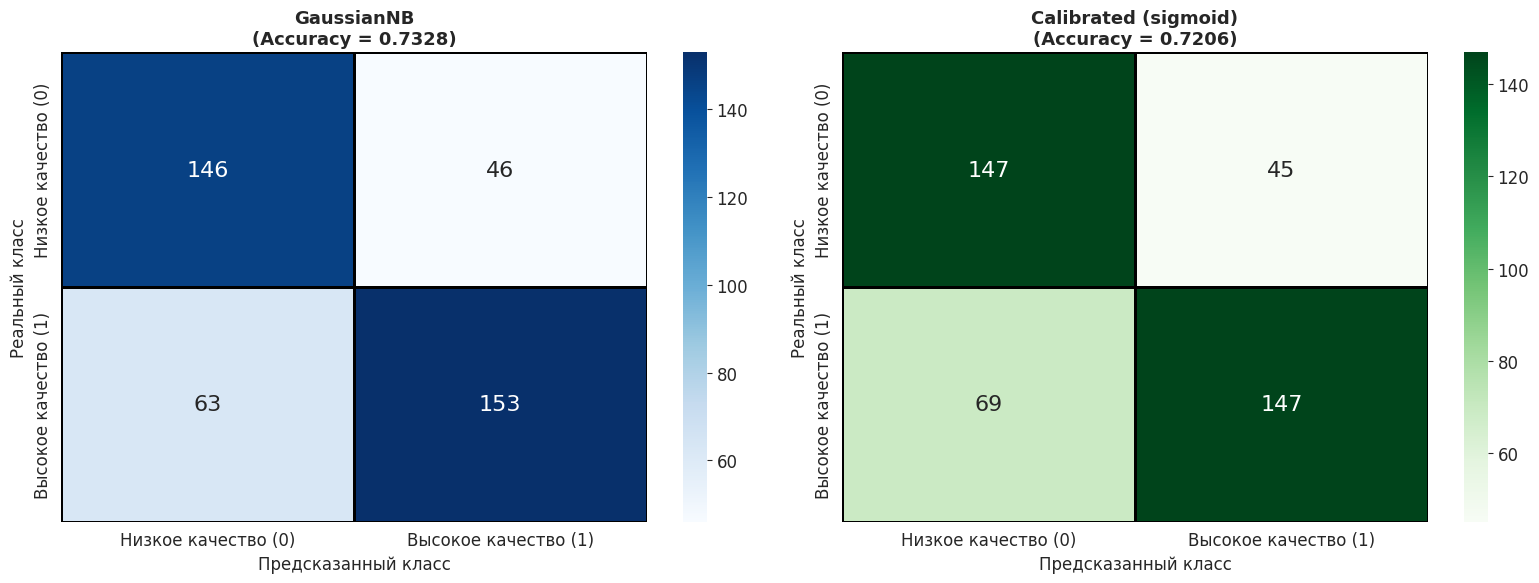

In [126]:
# ==============================
# ГРАФИК 1: Сравнение матриц ошибок
# ==============================

color_gnb = '#e74c3c'
color_cal = '#2ecc71'
model_colors = [color_gnb, color_cal]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, name, y_p, cmap in zip(axes, model_names,
                                [y_pred_gnb, y_pred_cal],
                                ['Blues', 'Greens']):
    cm = confusion_matrix(y_test, y_p)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                xticklabels=target_names, yticklabels=target_names,
                annot_kws={'size': 16}, linewidths=1, linecolor='black')
    ax.set_xlabel('Предсказанный класс', fontsize=12)
    ax.set_ylabel('Реальный класс', fontsize=12)
    acc = accuracy_score(y_test, y_p)
    ax.set_title(f'{name}\n(Accuracy = {acc:.4f})', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

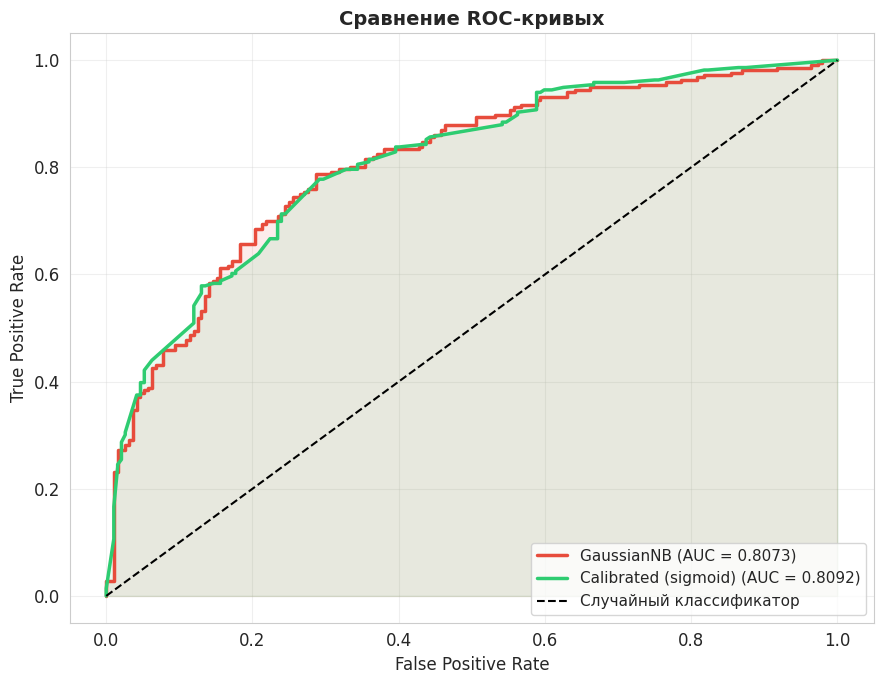

In [127]:
# ==============================
# ГРАФИК 2: Сравнение ROC-кривых
# ==============================

plt.figure(figsize=(9, 7))

for name, y_prob, color in zip(model_names,
                                [y_proba_gnb, y_proba_cal],
                                model_colors):
    fpr_m, tpr_m, _ = roc_curve(y_test, y_prob)
    auc_m = roc_auc_score(y_test, y_prob)
    plt.plot(fpr_m, tpr_m, color=color, lw=2.5,
             label=f'{name} (AUC = {auc_m:.4f})')
    plt.fill_between(fpr_m, tpr_m, alpha=0.1, color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Случайный классификатор')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Сравнение ROC-кривых', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

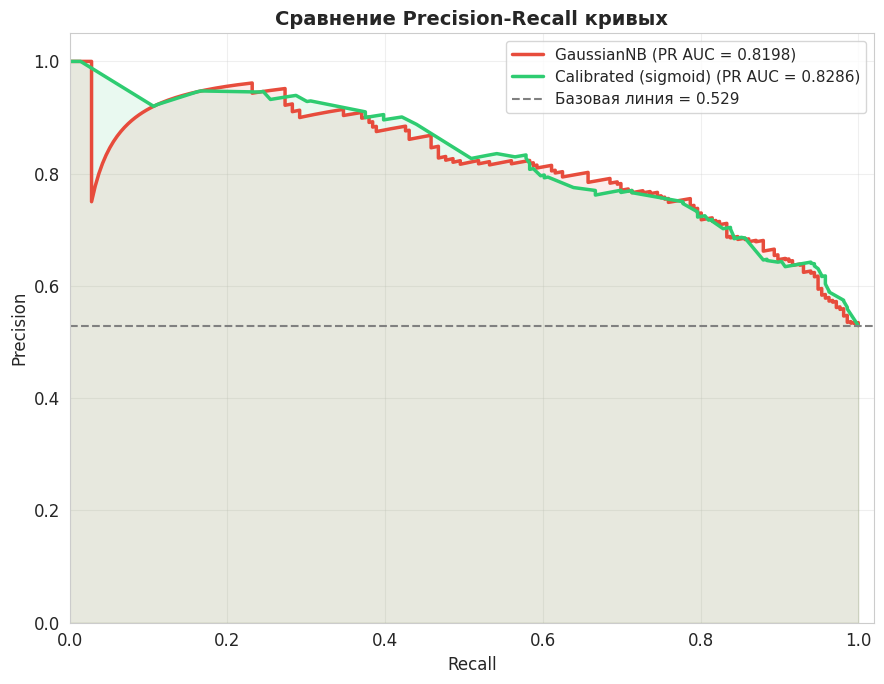

In [128]:
# ==============================
# ГРАФИК 3: Сравнение Precision-Recall кривых
# ==============================

plt.figure(figsize=(9, 7))

for name, y_prob, color in zip(model_names,
                                [y_proba_gnb, y_proba_cal],
                                model_colors):
    prec_m, rec_m, _ = precision_recall_curve(y_test, y_prob)
    pr_auc_m = auc(rec_m, prec_m)
    plt.plot(rec_m, prec_m, color=color, lw=2.5,
             label=f'{name} (PR AUC = {pr_auc_m:.4f})')
    plt.fill_between(rec_m, prec_m, alpha=0.1, color=color)

baseline = y_test.mean()
plt.axhline(y=baseline, color='gray', ls='--', lw=1.5,
            label=f'Базовая линия = {baseline:.3f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Сравнение Precision-Recall кривых', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xlim([0, 1.02])
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()

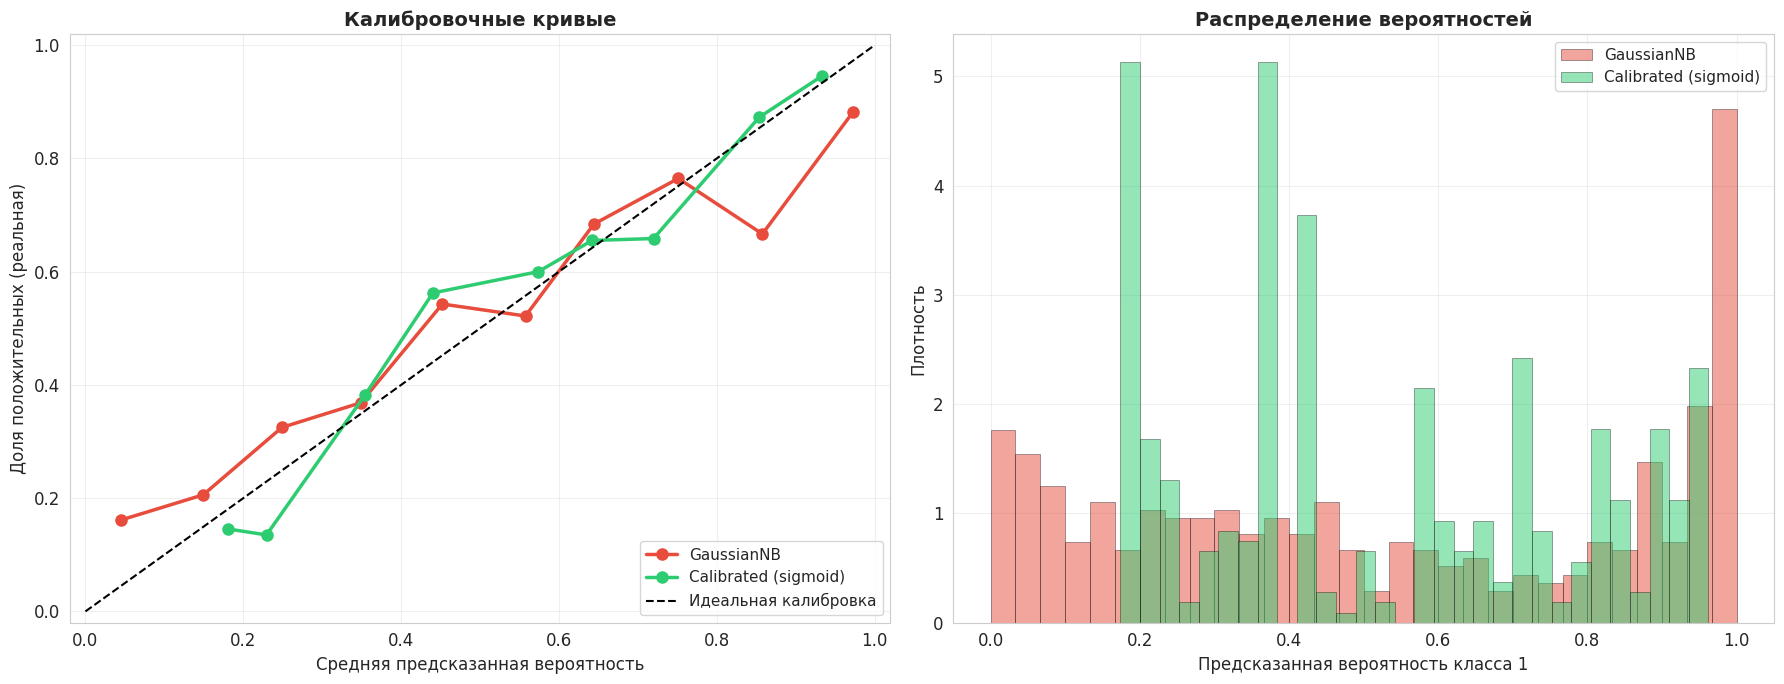

In [129]:
# ==============================
# ГРАФИК 4: Калибровочные кривые
# ==============================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for name, y_prob, color in zip(model_names,
                                [y_proba_gnb, y_proba_cal],
                                model_colors):
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')
    axes[0].plot(prob_pred, prob_true, 'o-', color=color, lw=2.5, markersize=8, label=name)

axes[0].plot([0, 1], [0, 1], 'k--', lw=1.5, label='Идеальная калибровка')
axes[0].set_xlabel('Средняя предсказанная вероятность', fontsize=12)
axes[0].set_ylabel('Доля положительных (реальная)', fontsize=12)
axes[0].set_title('Калибровочные кривые', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11, loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([-0.02, 1.02])
axes[0].set_ylim([-0.02, 1.02])

for name, y_prob, color in zip(model_names,
                                [y_proba_gnb, y_proba_cal],
                                model_colors):
    axes[1].hist(y_prob, bins=30, alpha=0.5, color=color,
                 edgecolor='black', linewidth=0.5, label=name, density=True)

axes[1].set_xlabel('Предсказанная вероятность класса 1', fontsize=12)
axes[1].set_ylabel('Плотность', fontsize=12)
axes[1].set_title('Распределение вероятностей', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

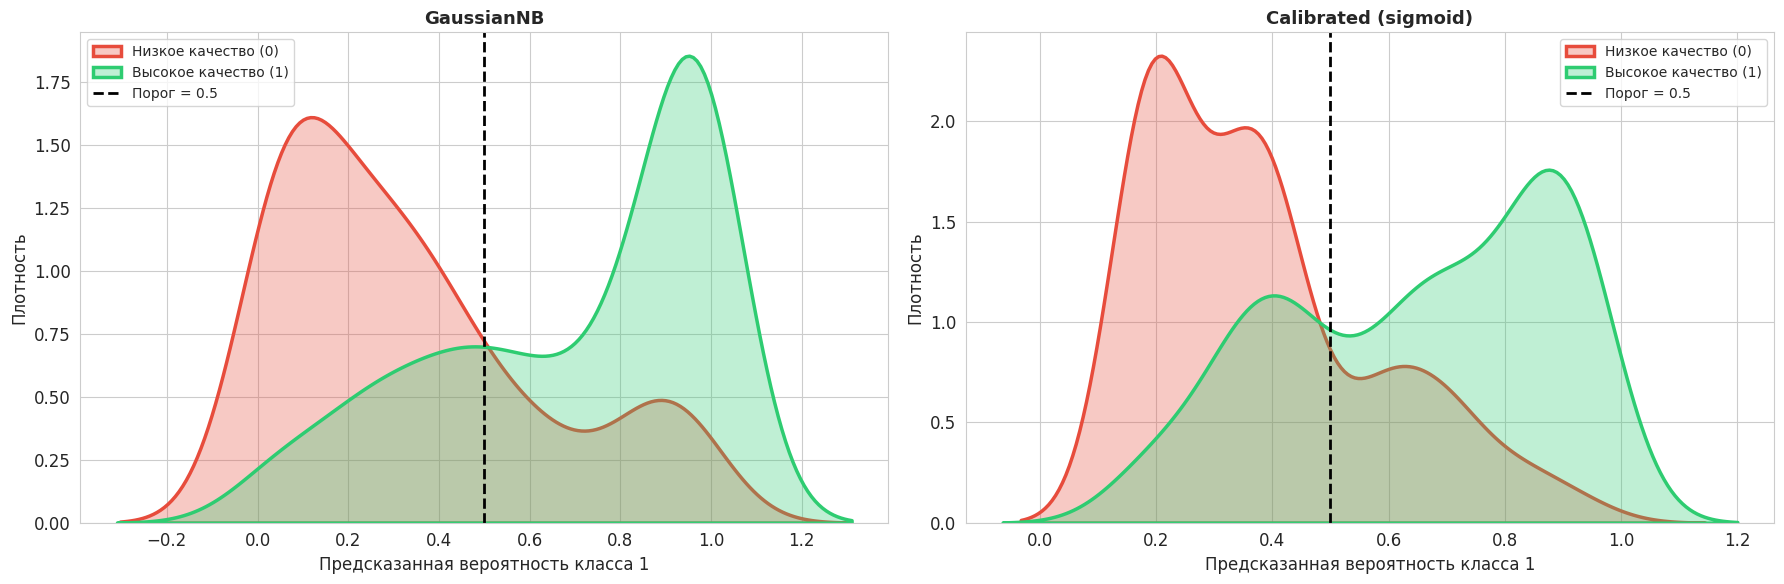

In [130]:
# ==============================
# ГРАФИК 5: Распределение вероятностей по реальным классам
# ==============================

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for ax, name, y_prob in zip(axes, model_names, [y_proba_gnb, y_proba_cal]):
    for cls, color, label in zip([0, 1], colors,
                                  ['Низкое качество (0)', 'Высокое качество (1)']):
        mask = y_test == cls
        sns.kdeplot(y_prob[mask], ax=ax, color=color,
                    lw=2.5, label=label, fill=True, alpha=0.3)
    ax.axvline(x=0.5, color='black', ls='--', lw=2, label='Порог = 0.5')
    ax.set_xlabel('Предсказанная вероятность класса 1', fontsize=12)
    ax.set_ylabel('Плотность', fontsize=12)
    ax.set_title(f'{name}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

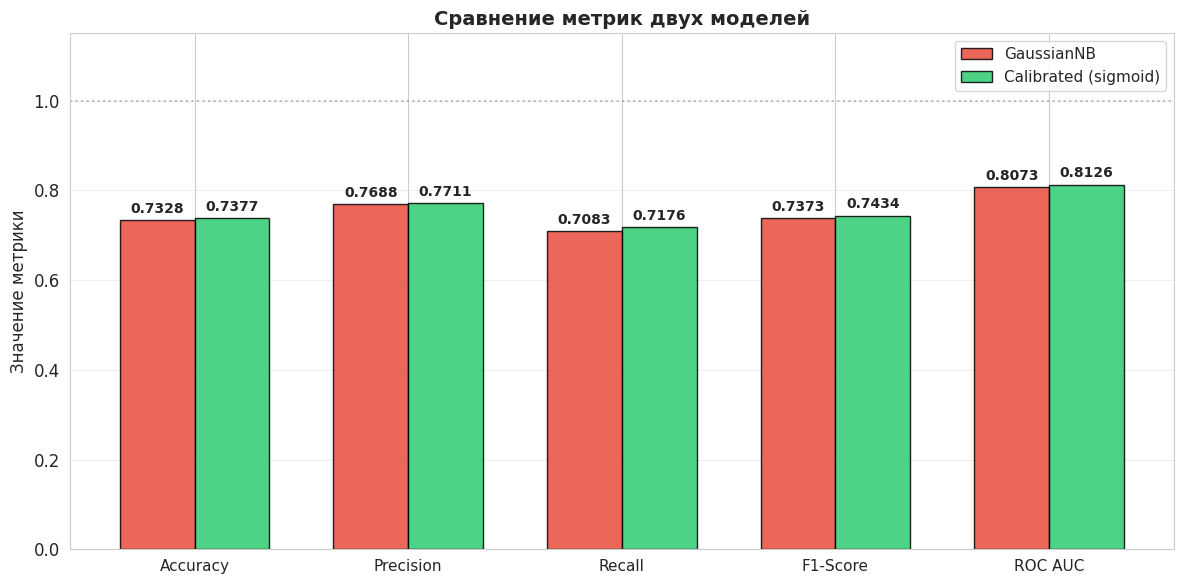

In [131]:
# ==============================
# ГРАФИК 6: Столбчатая диаграмма сравнения метрик
# ==============================

x = np.arange(len(metric_keys))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

vals_gnb = [all_results[model_names[0]][k] for k in metric_keys]
vals_cal = [all_results[model_names[1]][k] for k in metric_keys]

bars1 = ax.bar(x - width / 2, vals_gnb, width, label=model_names[0],
               color=color_gnb, edgecolor='black', alpha=0.85)
bars2 = ax.bar(x + width / 2, vals_cal, width, label=model_names[1],
               color=color_cal, edgecolor='black', alpha=0.85)

for bar, val in zip(bars1, vals_gnb):
    ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
for bar, val in zip(bars2, vals_cal):
    ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylim(0, 1.15)
ax.set_ylabel('Значение метрики', fontsize=12)
ax.set_title('Сравнение метрик двух моделей', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metric_keys, fontsize=11)
ax.legend(fontsize=11)
ax.axhline(y=1.0, color='gray', ls=':', alpha=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

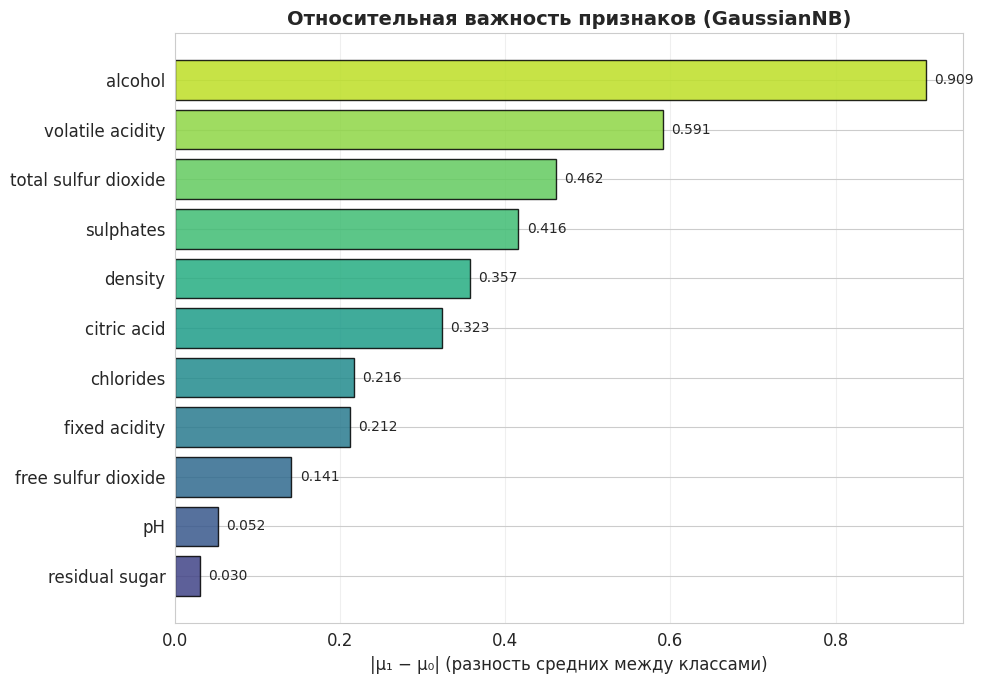

In [132]:
# ==============================
# ГРАФИК 7: Важность признаков (только для GaussianNB)
# ==============================

feature_importance = np.abs(model_gnb.theta_[1] - model_gnb.theta_[0])
importance_df = pd.DataFrame({
    'Признак': X.columns,
    'Важность': feature_importance
}).sort_values('Важность', ascending=True)

plt.figure(figsize=(10, 7))
bars = plt.barh(importance_df['Признак'], importance_df['Важность'],
                color=plt.cm.viridis(np.linspace(0.2, 0.9, len(importance_df))),
                edgecolor='black', alpha=0.85)
for bar, val in zip(bars, importance_df['Важность']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2.,
             f'{val:.3f}', va='center', fontsize=10)

plt.xlabel('|μ₁ − μ₀| (разность средних между классами)', fontsize=12)
plt.title('Относительная важность признаков (GaussianNB)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()